# Partícula libre en PBC

In [1]:
import openmm as mm
from openmm import unit
from openmm import app
import numpy as np
from matplotlib import pyplot as plt

## Creamos el sistema

In [2]:
molsys = mm.System()

In [3]:
molsys.addParticle(39.948 * unit.amu) # masa del átomo de argón

0

In [4]:
molsys.getNumParticles()

1

## Estado termodinámico

In [5]:
# Formalismo NVT
temperature = 700*unit.kelvin
pressure    = None

## Parametros de la simulación

In [6]:
integration_timestep = 0.001*unit.picoseconds
saving_timestep = 0.1*unit.picoseconds
simulation_time = 100*unit.picoseconds

saving_steps = int(saving_timestep/integration_timestep)
num_saving_steps = int(simulation_time/saving_timestep)

## Integrador

In [7]:
friction   = 50.0/unit.picosecond
integrator = mm.LangevinIntegrator(temperature, friction, integration_timestep)

## Plataforma

In [8]:
platform = mm.Platform.getPlatformByName('CUDA')

## Reporteros

In [9]:
times = np.zeros(num_saving_steps, np.float32) * unit.picoseconds
positions  = np.zeros([num_saving_steps,3], np.float32) * unit.angstroms
velocities = np.zeros([num_saving_steps,3], np.float32) * unit.angstroms/unit.picosecond
potential_energies   = np.zeros([num_saving_steps], np.float32) * unit.kilocalories_per_mole
kinetic_energies     = np.zeros([num_saving_steps], np.float32) * unit.kilocalories_per_mole

## Condiciones iniciales

In [10]:
initial_positions  = [[0.0, 0.0, 0.0]] * unit.angstroms

## Creamos el contexto

In [11]:
context = mm.Context(molsys, integrator, platform)

In [12]:
context.setPositions(initial_positions)

In [13]:
context.setVelocitiesToTemperature(temperature)

In [14]:
L = 2.0
v1 = [L,0,0] * unit.nanometers
v2 = [0,L,0] * unit.nanometers
v3 = [0,0,L] * unit.nanometers
L = L * unit.nanometers
context.setPeriodicBoxVectors(v1, v2, v3)

In [15]:
state = context.getState()
state.getPeriodicBoxVectors()

Quantity(value=[Vec3(x=2.0, y=0.0, z=0.0), Vec3(x=0.0, y=2.0, z=0.0), Vec3(x=0.0, y=0.0, z=2.0)], unit=nanometer)

## Llenamos los reporteros para el paso 0

In [16]:
state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)

In [17]:
times[0] =  state.getTime()
positions[0] = state.getPositions()[0]
velocities[0] = state.getVelocities()[0]
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

## Corriendo la simulación

In [18]:
for ii in range(1,num_saving_steps):
    context.getIntegrator().step(saving_steps)
    state_xx = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times[ii] = state_xx.getTime()
    positions[ii] = state_xx.getPositions()[0]
    velocities[ii] = state_xx.getVelocities()[0]
    kinetic_energies[ii]=state_xx.getKineticEnergy()
    potential_energies[ii]=state_xx.getPotentialEnergy()
    #print('Paso',ii,'con tiempo', state_xx.getTime())

## Representamos los datos de la simulación

### Trayectoria

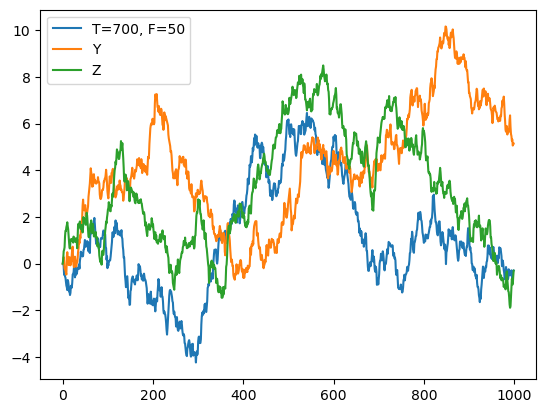

In [20]:
plt.plot(positions[:,0], label='T=700, F=50')
plt.plot(positions[:,1], label='Y')
plt.plot(positions[:,2], label='Z')
plt.legend()
plt.show()

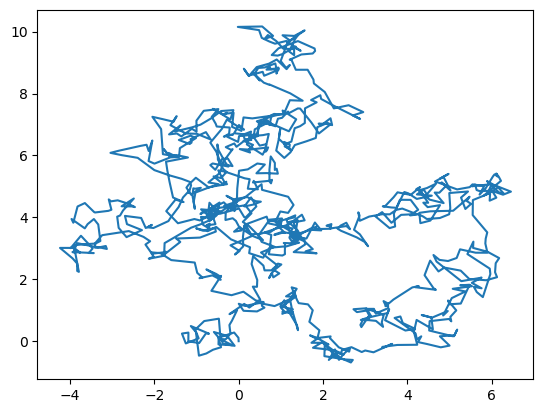

In [21]:
plt.plot(positions[:,0], positions[:,1])
plt.show()

In [22]:
n_frames = positions.shape[0]

wrapped_positions = np.zeros((n_frames,3)) * unit.nanometers

In [23]:
for ii in range(n_frames):

    x = positions[ii,0]
    

In [24]:
x = -3.0 * unit.nanometers

if x >= L:
    veces = int(x/L)
    print('Cuantas Ls le quito:', veces)
    x_wrapped = x-veces*L
elif x<0.0*unit.nanometers:
    veces = -int(x/L)+1
    print('Cuantas Ls le sumo:', veces)
    x_wrapped = x+veces*L
else:
    x_wrapped = x

print(x_wrapped)

Cuantas Ls le sumo: 2
1.0 nm


In [25]:
def corregir_pbc(trajectory, L):

    n_frames = trajectory.shape[0]
    wrapped_trajectory = np.zeros((n_frames,3)) * unit.nanometers

    for ii in range(n_frames):

        x = trajectory[ii,0]
        
        if x >= L:
            veces = int(x/L)
            x_wrapped = x-veces*L
        elif x<0.0*unit.nanometers:
            veces = -int(x/L)+1
            x_wrapped = x+veces*L
        else:
            x_wrapped = x

        y = trajectory[ii,1]
        
        if y >= L:
            veces = int(y/L)
            y_wrapped = y-veces*L
        elif y<0.0*unit.nanometers:
            veces = -int(y/L)+1
            y_wrapped = y+veces*L
        else:
            y_wrapped = y

        z = trajectory[ii,2]
        
        if z >= L:
            veces = int(z/L)
            z_wrapped = z-veces*L
        elif z<0.0*unit.nanometers:
            veces = -int(z/L)+1
            z_wrapped = z+veces*L
        else:
            z_wrapped = z

        wrapped_trajectory[ii,0] = x_wrapped
        wrapped_trajectory[ii,1] = y_wrapped
        wrapped_trajectory[ii,2] = z_wrapped

    return wrapped_trajectory

In [26]:
good_positions = corregir_pbc(positions, L)

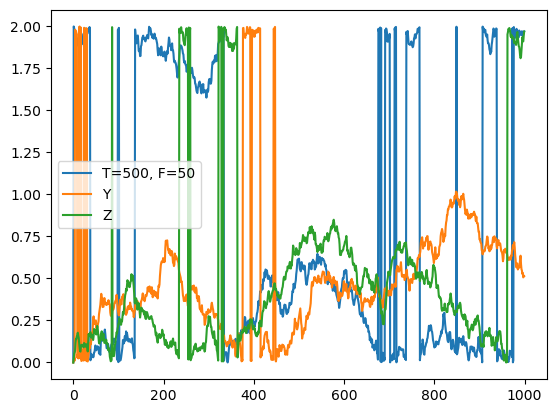

In [27]:
plt.plot(good_positions[:,0], label='T=500, F=50')
plt.plot(good_positions[:,1], label='Y')
plt.plot(good_positions[:,2], label='Z')
plt.legend()
plt.show()

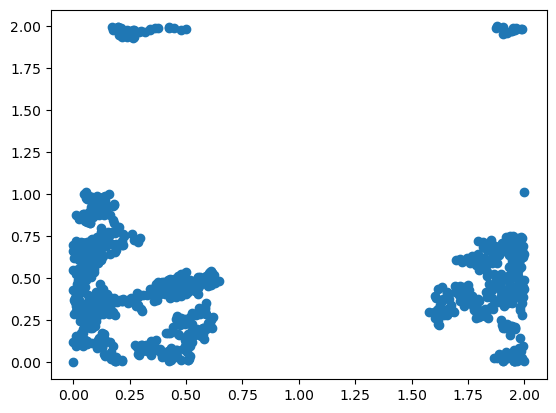

In [28]:
plt.scatter(good_positions[:,0], good_positions[:,1])
plt.show()